In [ ]:
!curl -L http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz -O && tar xzvf ta-lib-0.4.0-src.tar.gz
!cd ta-lib && ./configure --prefix=/usr && make && make install && cd - && pip install ta-lib
#%pip install TA-Lib
#!pip install TA-Lib
#pip install talib-binary

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   380  100   380    0     0   3193      0 --:--:-- --:--:-- --:--:--  3193
100   355  100   355    0     0   1563      0 --:--:-- --:--:-- --:--:--  1563
100 1299k  100 1299k    0     0  1555k      0 --:--:-- --:--:-- --:--:-- 4157k
ta-lib/
ta-lib/config.sub
ta-lib/aclocal.m4
ta-lib/CHANGELOG.TXT
ta-lib/include/
ta-lib/include/ta_abstract.h
ta-lib/include/ta_func.h
ta-lib/include/ta_common.h
ta-lib/include/ta_config.h.in
ta-lib/include/Makefile.am
ta-lib/include/ta_libc.h
ta-lib/include/ta_defs.h
ta-lib/missing
ta-lib/ta-lib.spec.in
ta-lib/config.guess
ta-lib/Makefile.in
ta-lib/ta-lib.dpkg.in
ta-lib/Makefile.am
ta-lib/autogen.sh
ta-lib/install-sh
ta-lib/configure
ta-lib/depcomp
ta-lib/HISTORY.TXT
ta-lib/configure.in
ta-lib/autom4te.cache/
ta-lib/autom4te.cache/output.0
ta-lib/autom4te.cache/requests
ta-lib/autom4te.cache/outpu

In [ ]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [ ]:

import sklearn.metrics as skm

import pandas as pd
import numpy as np
import talib
import datetime as dt
import time
import pickle
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [ ]:
sp500=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]#este es el dataframe completo
sp500_tickers=list(sp500.Symbol)# ACA paso a lista una columna del dataframe (symbol)
tickers=[e for e in sp500_tickers if e not in ('BRK.B','BF.B','CEG')]
sp_sector=sp500.loc[:,'GICS Sector']
sp_sector.index=sp500.loc[:,'Symbol']
sp_sector=pd.DataFrame(sp_sector)

sp_tec=np.where(sp_sector['GICS Sector']=='Information Technology','True','False')
sp_tec=pd.DataFrame(sp_tec)


sp_tec.columns=['GICS Sector']
sp_tec['symbol']=sp_sector.index
sp_tec.index=sp_tec['GICS Sector']
sp_tec=sp_tec.drop('False',axis=0)
tickers_sec=sp_tec.symbol.to_list()



tickers1=tickers_sec#:20]#tickers[:3]

Traemos del Drive la funcion que hace la bajada de la data actual

In [ ]:
import gc
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%run "/content/drive/My Drive/alpha_key.py"
%run "/content/drive/My Drive/Colab Notebooks/fun_data_actual.ipynb"




Mounted at /content/drive


BAJADA DE DATA ACTUAL

In [ ]:
j=range(0,5000,5)# esto lo hacemos para que espere 60 segundos dado que la api solo baja 5 datos por min
cant_request=1
data_pred = {}
for t in tickers1:
    
    ahora = dt.datetime.now()
    if cant_request not in j:
      data_pred[t] = traerSeries(t,'15min','full')['Close']
    else:
      time.sleep(60)
      data_pred [t]= traerSeries(t,'15min','full')['Close']
            
    cant_request=1+cant_request

procesando activoACN
procesando activoADBE
procesando activoADP
procesando activoAKAM
procesando activoAMD
procesando activoAPH
procesando activoADI
procesando activoANSS
procesando activoAAPL
procesando activoAMAT
procesando activoANET
procesando activoADSK
procesando activoAVGO
procesando activoBR
procesando activoCDNS
procesando activoCDW
procesando activoCDAY
procesando activoCSCO
procesando activoCTSH
procesando activoGLW
procesando activoDXC
procesando activoENPH
procesando activoEPAM
procesando activoFFIV
procesando activoFIS
procesando activoFISV
procesando activoFLT
procesando activoFTNT
procesando activoIT
procesando activoGEN
procesando activoGPN
procesando activoHPE
procesando activoHPQ
procesando activoIBM
procesando activoINTC
procesando activoINTU
procesando activoJKHY
procesando activoJNPR
procesando activoKEYS
procesando activoKLAC
procesando activoLRCX
procesando activoMA
procesando activoMCHP
procesando activoMU
procesando activoMSFT
procesando activoMPWR
procesando 

In [ ]:
data_pred=pd.DataFrame(data_pred)
data_pred=data_pred.dropna().apply(pd.to_numeric)
data_pred.sort_index(inplace=True)
data_pred


# Guardamos data actual
pick_insert = open('drive/My Drive/dataActual.pickle','xb')
pickle.dump(data_pred, pick_insert)
pick_insert.close()


Aca traemos la data bajada previamente (esto es para que se vea lo que bajamos al momento de dejar plasmada la prediccion)

In [ ]:
import gc
import pickle

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
   
pick_read = open('drive/My Drive/dataActual.pickle','rb')
data = pickle.load(pick_read)
pick_read.close()
data_pred=data

Mounted at /content/drive


Trae los modelo ya entrenados, calcula los indicadores para la data actual y precide

In [ ]:
data_pred=data.iloc[:-20,]# esto lo hacemos para que la prediccion sea para el mismo dia


In [ ]:
pick_read = open('drive/My Drive/modeloAAPL.pickle','rb')
model = pickle.load(pick_read)
prediccion=[]
X=pd.DataFrame()
ventana=15
for stock in tickers1:
    
    # Se calculan los indicadores para la data actual
    X['cruce'] = data_pred[stock].rolling(12).mean()/data_pred[stock].rolling(26).mean()-1 #aproximadamente 12 d'ias y 26 dias, porque hay 25 datos diarios
    X['APO'] = talib.APO(data_pred[stock], fastperiod=25, slowperiod=50, matype=0)#(Absolute price oscillator, Es una diferencia de medias móviles, simples, exponenciales, etc) ES COMO EL CRUCE
    X['RSI9'] = talib.RSI(data_pred[stock], timeperiod=9)
    X['RSI14'] = talib.RSI(data_pred[stock], timeperiod=14)
    X['MOM'] = talib.MOM(data_pred[stock], timeperiod=ventana)#•	MOM ( "Momentum", es la diferencia entre el precio y el precio "n" ruedas atrás)
    
    
    X=X.dropna()

    y_pred = model.predict(X[-1:])
    prediccion.append(y_pred)


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without featu

In [ ]:
resultados=pd.DataFrame(prediccion)
resultados.index=tickers1
resultados.columns=['prediccion']
resultados

,prediccion
ACN,baja
ADBE,sube
ADP,baja
AKAM,baja
AMD,sube
...,...
TYL,sube
VRSN,sube
V,baja
WDC,baja


In [ ]:
resultados.head(40)

,prediccion
ACN,baja
ADBE,sube
ADP,baja
AKAM,baja
AMD,sube
APH,baja
ADI,baja
ANSS,baja
AAPL,baja
AMAT,baja


In [ ]:
resultados.tail(35)

,prediccion
LRCX,baja
MA,baja
MCHP,baja
MU,baja
MSFT,baja
MPWR,baja
MSI,baja
NTAP,baja
NVDA,baja
NXPI,baja


Plotteamos los ultimos datos de algunos activos

In [ ]:
# aramamos un dataframe con base 100 al momento en que se realizo la prediccion
base100=pd.DataFrame()
for stock in tickers1:
    datin=data.iloc[-16:,:]
    base100[stock]=((datin[stock].pct_change())+1).cumprod()*100
base100.iloc[0:1,:]=100

In [ ]:
base100

,ACN,ADBE,ADP,AKAM,AMD,APH,ADI,ANSS,AAPL,AMAT,...,TEL,TDY,TER,TXN,TRMB,TYL,VRSN,V,WDC,ZBRA
Time,,,,,,,,,,,,,,,,,,,,,
2022-12-05 12:30:00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2022-12-05 12:45:00,99.690276,99.542615,99.860709,99.502245,99.756564,99.682590,100.005962,99.408167,99.777295,99.901404,...,99.814141,99.717849,99.924877,99.842453,99.808589,99.388287,99.613304,99.637732,99.785162,99.210046
2022-12-05 13:00:00,99.636432,99.518699,99.921244,99.588811,99.326781,99.698303,100.059616,99.126152,99.639921,99.816893,...,99.967677,99.637739,99.892681,99.805880,100.033289,98.818969,99.542537,99.593609,99.842452,98.841152
2022-12-05 13:15:00,99.884279,99.768318,100.014682,99.648325,99.569005,99.830295,100.304042,99.213537,99.785991,100.211278,...,100.113131,99.875712,100.268298,99.856520,100.278628,98.785658,99.691654,99.781339,100.148954,98.900771
2022-12-05 13:30:00,99.668153,99.766823,99.800474,99.648325,99.394103,99.698303,100.393466,99.316810,99.660303,100.164327,...,100.048485,99.854506,100.096587,100.045801,99.912117,98.532796,99.580448,99.684176,100.143225,98.677199
2022-12-05 13:45:00,99.611994,99.790739,99.890826,99.637505,99.501818,99.849151,100.369620,99.161900,99.633127,100.107986,...,100.169697,99.762616,100.107319,100.109720,99.956724,98.443462,99.555174,99.758488,99.885420,98.597086
2022-12-05 14:00:00,99.094653,99.363248,99.555773,99.128929,98.478524,99.685732,99.913557,98.605815,99.300360,99.394338,...,100.008081,99.785753,99.559991,99.637080,99.858522,98.001332,99.570338,99.368353,99.298195,98.157395
2022-12-05 14:15:00,99.346516,99.539625,99.593419,99.410269,99.044029,99.685732,100.228031,98.975214,99.480264,99.732382,...,99.927273,99.663468,99.715604,99.838683,99.983356,98.155775,99.883739,99.414797,99.641936,98.449901
2022-12-05 14:30:00,99.159321,99.104661,99.424011,99.204675,98.868992,99.396606,99.904614,98.653480,99.259461,99.384948,...,99.668687,99.609465,99.506332,99.614573,99.525632,98.054327,99.643633,99.261530,99.513034,98.239371


In [ ]:
# Etiquetamos el ultimo resultado con suba o baja
listares=np.where(base100.iloc[-1,:]<100,"baja","sube")
res=pd.DataFrame(listares)  
res.index=tickers1


In [ ]:
res.tail(40)

,0
INTU,baja
JKHY,baja
JNPR,sube
KEYS,baja
KLAC,baja
LRCX,baja
MA,baja
MCHP,baja
MU,baja
MSFT,baja


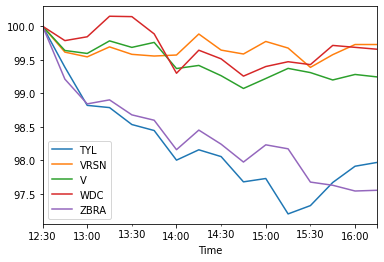

In [ ]:
base100.iloc[:,-5:].plot()

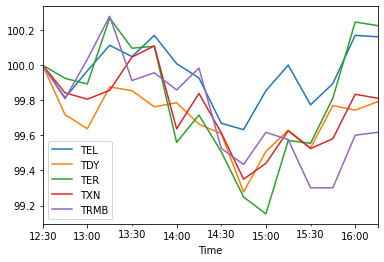

In [ ]:
base100.iloc[:,-10:-5].plot()

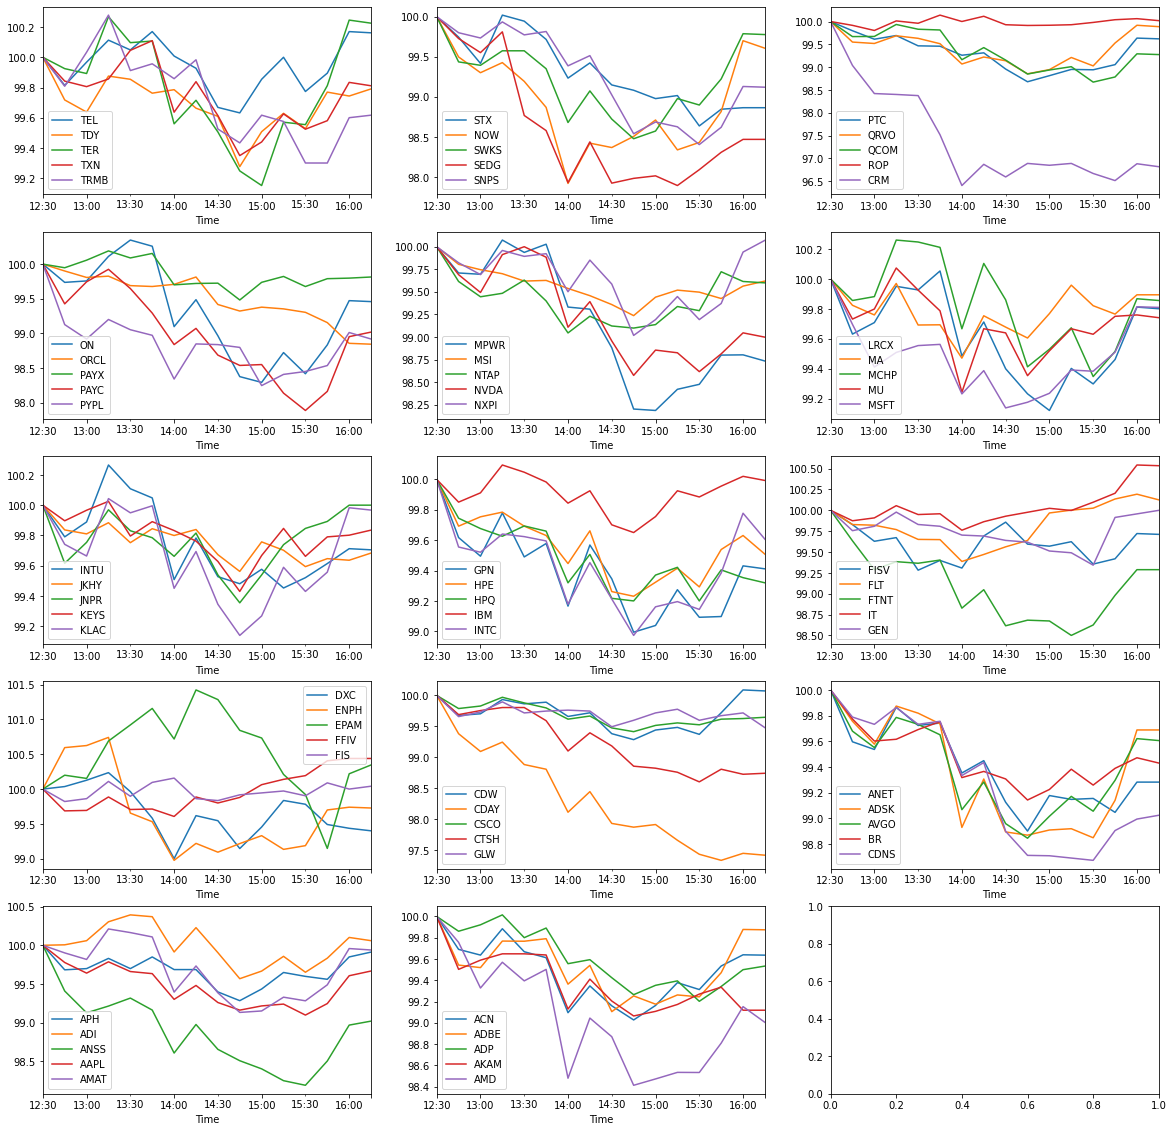

In [ ]:
fig, ax = plt.subplots(figsize=(20,20),nrows=5,ncols=3)
columnas=3
for a in range (1,15):
  row=(a-1)//columnas 
  col=(a-1)%columnas  
  
  ax[row][col] =base100.iloc[:,(-5*a)-5:(-5*a)].plot(ax=ax[row][col])
  


In [ ]:
pick_read = open('drive/My Drive/modeloAAPL.pickle','rb')
model = pickle.load(pick_read)
prediccion=[]
for stock in tickers1:
    #from google.colab import drive
    #drive.mount('/content/drive', force_remount=True)
    #pick_read = open('drive/My Drive/modelo_'+stock+'.pickle','rb')
    #model = pickle.load(pick_read)
    y_pred = model.predict(X[-1:])
    prediccion.append(y_pred)
    

resultados=pd.DataFrame(prediccion)
